<a href="https://colab.research.google.com/github/chaitanyya007/major_project_118/blob/main/QRl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pennylane torch matplotlib numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 56.1 MB/s eta 0:00:00


In [ ]:
# ==========================================================
# Quantum Reinforcement Learning for Vehicle Routing Problem
# 1 Depot, 4 Customers, 2 Vehicles
# Tracks routes per episode and prints best route at the end
# ==========================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# -------------------------------
# ENVIRONMENT SETUP
# -------------------------------
class VRPEnvironment:
    def __init__(self):
        self.depot = (0, 0)
        self.customers = [(2, 3), (5, 4), (6, 1), (3, 6)]  # fixed points
        self.num_customers = len(self.customers)
        self.num_vehicles = 2
        self.reset()

    def reset(self):
        self.visited = [False] * self.num_customers
        self.vehicle_positions = [self.depot for _ in range(self.num_vehicles)]
        self.total_distance = 0
        self.steps = 0
        return self._get_state()

    def _distance(self, a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def _get_state(self):
        state = []
        for pos in self.vehicle_positions:
            state.extend(list(pos))
        state.extend([1.0 if v else 0.0 for v in self.visited])
        return np.array(state)

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5, all(self.visited)  # penalty for revisit

        curr_pos = self.vehicle_positions[vehicle_idx]
        new_pos = self.customers[customer_idx]
        dist = self._distance(curr_pos, new_pos)
        self.vehicle_positions[vehicle_idx] = new_pos
        self.visited[customer_idx] = True
        self.total_distance += dist
        self.steps += 1

        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist


# -------------------------------
# QUANTUM POLICY NETWORK
# -------------------------------
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_policy(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)

    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)

    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class QuantumPolicy(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_qubits, 2) * 0.1)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        probs = quantum_policy(x, self.weights)
        probs = torch.tensor(probs)
        probs = (probs + 1) / 2
        return probs / torch.sum(probs)


# -------------------------------
# TRAINING LOOP
# -------------------------------
env = VRPEnvironment()
policy = QuantumPolicy(n_qubits)
optimizer = optim.Adam(policy.parameters(), lr=0.05)
num_episodes = 150

episode_rewards = []
best_route = None
best_distance = float("inf")

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    route_log = [[] for _ in range(env.num_vehicles)]
    route_distance = 0

    for step in range(10):  # max steps
        with torch.no_grad():
            probs = policy(state)
        probs_np = probs.numpy()
        vehicle_idx = random.randint(0, env.num_vehicles - 1)
        customer_idx = np.random.choice(env.num_customers, p=np.abs(probs_np[:env.num_customers]) / np.sum(np.abs(probs_np[:env.num_customers])))

        next_state, reward, done, dist = env.step(vehicle_idx, customer_idx)
        total_reward += reward
        route_distance += dist
        route_log[vehicle_idx].append(f"C{customer_idx + 1}")

        loss = -torch.log(probs[customer_idx] + 1e-6) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        if done:
            break

    episode_rewards.append(total_reward)

    print(f"\nEpisode {ep + 1}")
    for i, route in enumerate(route_log):
        if not route:
            print(f"  Vehicle {i+1}: Did not move.")
        else:
            print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
    print(f"  Total Distance: {route_distance:.3f}, Total Reward: {total_reward:.3f}")

    if route_distance < best_distance:
        best_distance = route_distance
        best_route = route_log

print("\n===============================")
print("🏆 Best Route Found Across All Episodes:")
for i, route in enumerate(best_route):
    if not route:
        print(f"  Vehicle {i+1}: Did not move.")
    else:
        print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
print(f"  🚗 Best Total Distance: {best_distance:.3f}")
print("===============================\n")

# -------------------------------
# VISUALIZATION
# -------------------------------
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.title("QRL Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Show best final routes visually
plt.figure(figsize=(6, 6))
plt.scatter(*env.depot, color="red", marker="s", s=100, label="Depot")
for i, c in enumerate(env.customers):
    plt.scatter(*c, color="blue", s=80)
    plt.text(c[0] + 0.1, c[1], f"C{i + 1}")

colors = ["green", "purple"]
for i, route in enumerate(best_route):
    route_points = [env.depot] + [env.customers[int(r[1]) - 1] for r in route] + [env.depot]
    xs, ys = zip(*route_points)
    plt.plot(xs, ys, marker="o", linestyle="-", color=colors[i], label=f"Vehicle {i+1}")

plt.title("Best Routes Found by QRL Agent")
plt.legend()
plt.show()


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn


Episode 1
  Vehicle 1 route: Depot -> C1 -> Depot
  Vehicle 2 route: Depot -> C2 -> C4 -> C2 -> C2 -> C3 -> Depot
  Total Distance: 18.668, Total Reward: -28.668

Episode 2
  Vehicle 1 route: Depot -> C1 -> C1 -> Depot
  Vehicle 2 route: Depot -> C2 -> C2 -> C2 -> C4 -> C3 -> Depot
  Total Distance: 18.668, Total Reward: -33.668

Episode 3
  Vehicle 1 route: Depot -> C1 -> Depot
  Vehicle 2 route: Depot -> C3 -> C2 -> C4 -> Depot
  Total Distance: 15.679, Total Reward: -15.679

Episode 4
  Vehicle 1 route: Depot -> C3 -> Depot
  Vehicle 2 route: Depot -> C1 -> C2 -> C1 -> C2 -> C1 -> C4 -> Depot
  Total Distance: 15.679, Total Reward: -30.679

Episode 5
  Vehicle 1 route: Depot -> C2 -> C1 -> C1 -> C4 -> Depot
  Vehicle 2 route: Depot -> C3 -> C1 -> C3 -> C2 -> Depot
  Total Distance: 19.786, Total Reward: -39.786

Episode 6
  Vehicle 1 route: Depot -> C4 -> C4 -> C3 -> C3 -> C4 -> C4 -> Depot
  Vehicle 2 route: Depot -> C3 -> C2 -> C3 -> C4 -> Depot
  Total Distance: 15.953, Total Re

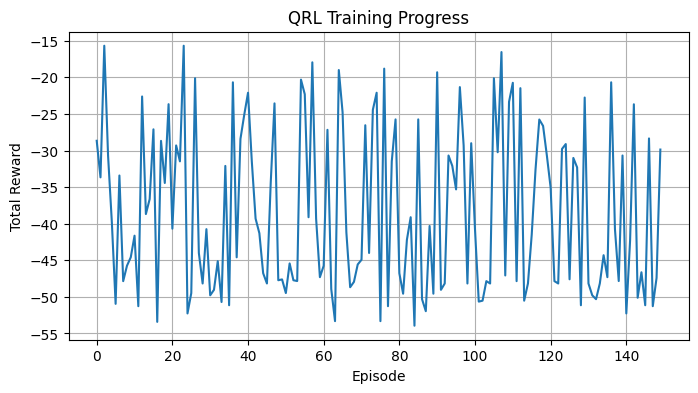

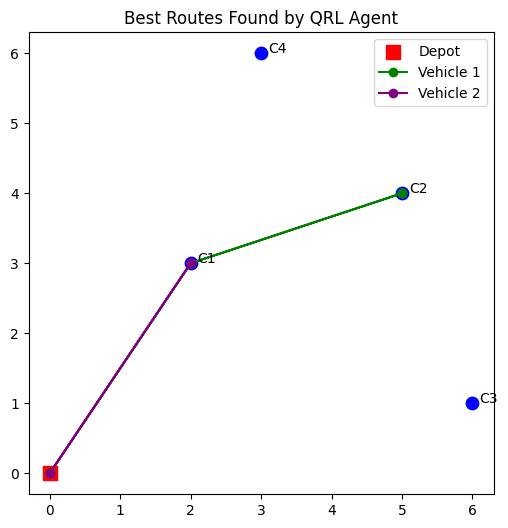

In [ ]:
# ==========================================================
# Quantum Reinforcement Learning for Vehicle Routing Problem
# 1 Depot, 4 Customers, 2 Vehicles
# Tracks routes per episode and prints best route at the end
# ==========================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# -------------------------------
# ENVIRONMENT SETUP
# -------------------------------
class VRPEnvironment:
    def __init__(self):
        self.depot = (0, 0)
        self.customers = [(2, 3), (5, 4), (6, 1), (3, 6)]  # fixed points
        self.num_customers = len(self.customers)
        self.num_vehicles = 2
        self.reset()

    def reset(self):
        self.visited = [False] * self.num_customers
        self.vehicle_positions = [self.depot for _ in range(self.num_vehicles)]
        self.total_distance = 0
        self.steps = 0
        return self._get_state()

    def _distance(self, a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def _get_state(self):
        state = []
        for pos in self.vehicle_positions:
            state.extend(list(pos))
        state.extend([1.0 if v else 0.0 for v in self.visited])
        return np.array(state)

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5, all(self.visited), 0  # penalty for revisit

        curr_pos = self.vehicle_positions[vehicle_idx]
        new_pos = self.customers[customer_idx]
        dist = self._distance(curr_pos, new_pos)
        self.vehicle_positions[vehicle_idx] = new_pos
        self.visited[customer_idx] = True
        self.total_distance += dist
        self.steps += 1

        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist


# -------------------------------
# QUANTUM POLICY NETWORK
# -------------------------------
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_policy(inputs, weights):
    # Encode classical state into quantum rotations
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)

    # Variational quantum circuit
    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)

    # Entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class QuantumPolicy(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_qubits, 2) * 0.1)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=False)
        probs = quantum_policy(x, self.weights)
        probs = torch.stack(probs)
        probs = (probs + 1) / 2
        return probs / torch.sum(probs)


# -------------------------------
# TRAINING LOOP
# -------------------------------
env = VRPEnvironment()
policy = QuantumPolicy(n_qubits)
optimizer = optim.Adam(policy.parameters(), lr=0.05)
num_episodes = 150

episode_rewards = []
best_route = None
best_distance = float("inf")

for ep in range(num_episodes):
    state = env.reset()
    total_reward = 0
    route_log = [[] for _ in range(env.num_vehicles)]
    route_distance = 0

    for step in range(10):  # max steps
        probs = policy(state)  # <-- training step, so no torch.no_grad()
        probs_np = probs.detach().numpy()

        vehicle_idx = random.randint(0, env.num_vehicles - 1)
        customer_idx = np.random.choice(
            env.num_customers,
            p=np.abs(probs_np[:env.num_customers])
            / np.sum(np.abs(probs_np[:env.num_customers])),
        )

        next_state, reward, done, dist = env.step(vehicle_idx, customer_idx)
        total_reward += reward
        route_distance += dist
        route_log[vehicle_idx].append(f"C{customer_idx + 1}")

        loss = -torch.log(probs[customer_idx] + 1e-6) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        if done:
            break

    episode_rewards.append(total_reward)

    print(f"\nEpisode {ep + 1}")
    for i, route in enumerate(route_log):
        if not route:
            print(f"  Vehicle {i+1}: Did not move.")
        else:
            print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
    print(f"  Total Distance: {route_distance:.3f}, Total Reward: {total_reward:.3f}")

    if route_distance < best_distance:
        best_distance = route_distance
        best_route = route_log

print("\n===============================")
print("🏆 Best Route Found Across All Episodes:")
for i, route in enumerate(best_route):
    if not route:
        print(f"  Vehicle {i+1}: Did not move.")
    else:
        print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
print(f"  🚗 Best Total Distance: {best_distance:.3f}")
print("===============================\n")

# -------------------------------
# VISUALIZATION
# -------------------------------
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.title("QRL Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Show best final routes visually
plt.figure(figsize=(6, 6))
plt.scatter(*env.depot, color="red", marker="s", s=100, label="Depot")
for i, c in enumerate(env.customers):
    plt.scatter(*c, color="blue", s=80)
    plt.text(c[0] + 0.1, c[1], f"C{i + 1}")

colors = ["green", "purple"]
for i, route in enumerate(best_route):
    route_points = [env.depot] + [
        env.customers[int(r[1]) - 1] for r in route
    ] + [env.depot]
    xs, ys = zip(*route_points)
    plt.plot(xs, ys, marker="o", linestyle="-", color=colors[i], label=f"Vehicle {i+1}")

plt.title("Best Routes Found by QRL Agent")
plt.legend()
plt.show()



Episode 1
  Vehicle 1 route: Depot -> C1 -> C2 -> C4 -> C9 -> C10 -> C5 -> C7 -> Depot
  Vehicle 2 route: Depot -> C6 -> C8 -> C3 -> Depot
  Total Distance: 29.541, Total Reward: -29.541

Episode 2
  Vehicle 1 route: Depot -> C8 -> C4 -> C6 -> C9 -> C5 -> Depot
  Vehicle 2 route: Depot -> C10 -> C2 -> C1 -> C3 -> C7 -> Depot
  Total Distance: 39.012, Total Reward: -39.012

Episode 3
  Vehicle 1 route: Depot -> C5 -> C9 -> C1 -> C3 -> C10 -> C6 -> C4 -> Depot
  Vehicle 2 route: Depot -> C8 -> C2 -> C7 -> Depot
  Total Distance: 38.722, Total Reward: -38.722

Episode 4
  Vehicle 1 route: Depot -> C3 -> C2 -> C1 -> C9 -> C5 -> C4 -> C7 -> Depot
  Vehicle 2 route: Depot -> C8 -> C6 -> C10 -> Depot
  Total Distance: 34.844, Total Reward: -34.844

Episode 5
  Vehicle 1 route: Depot -> C7 -> Depot
  Vehicle 2 route: Depot -> C6 -> C9 -> C5 -> C8 -> C10 -> C2 -> C3 -> C4 -> C1 -> Depot
  Total Distance: 39.175, Total Reward: -39.175

Episode 6
  Vehicle 1 route: Depot -> C5 -> C9 -> C2 -> C3 

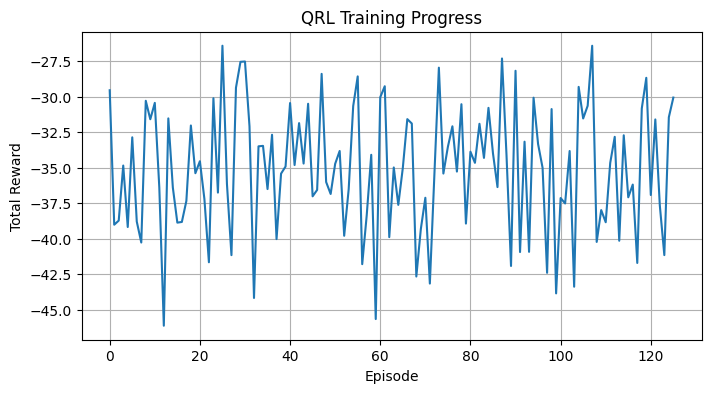

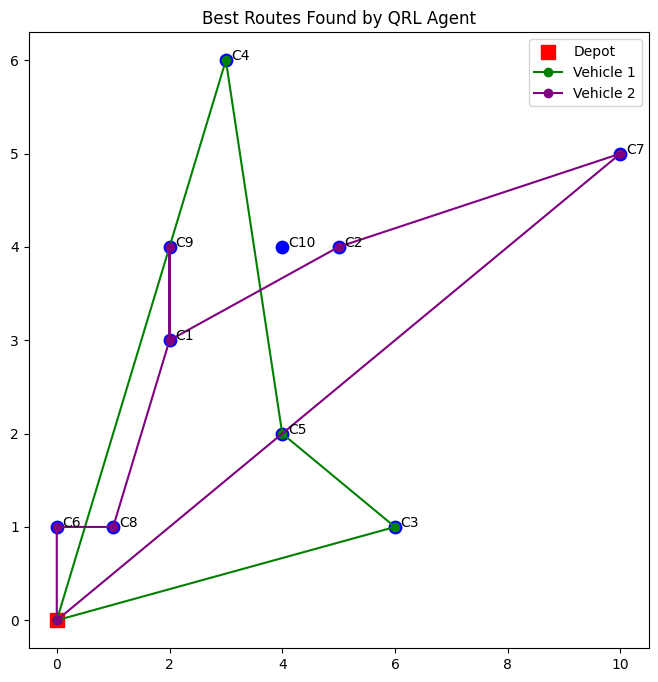

In [ ]:
# ==========================================================
# Quantum Reinforcement Learning for Vehicle Routing Problem
# 1 Depot, 10 Customers, 2 Vehicles
# Adaptive stopping + both vehicles encouraged
# ==========================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# -------------------------------
# ENVIRONMENT SETUP (10 customers)
# -------------------------------
class VRPEnvironment:
    def __init__(self):
        self.depot = (0, 0)
        self.customers = [
            (2, 3), (5, 4), (6, 1), (3, 6), (4, 2),
            (0, 1), (10, 5), (1, 1), (2, 4), (4, 4)
        ]
        self.num_customers = len(self.customers)
        self.num_vehicles = 2
        self.reset()

    def reset(self):
        self.visited = [False] * self.num_customers
        self.vehicle_positions = [self.depot for _ in range(self.num_vehicles)]
        self.total_distance = 0
        self.steps = 0
        return self._get_state()

    def _distance(self, a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def _get_state(self):
        state = []
        for pos in self.vehicle_positions:
            state.extend(list(pos))
        state.extend([1.0 if v else 0.0 for v in self.visited])
        return np.array(state)

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5, all(self.visited), 0  # penalty

        curr_pos = self.vehicle_positions[vehicle_idx]
        new_pos = self.customers[customer_idx]
        dist = self._distance(curr_pos, new_pos)
        self.vehicle_positions[vehicle_idx] = new_pos
        self.visited[customer_idx] = True
        self.total_distance += dist
        self.steps += 1

        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist


# -------------------------------
# QUANTUM POLICY NETWORK
# -------------------------------
n_qubits = 10  # one qubit per customer
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_policy(inputs, weights):
    # Encode classical state
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)

    # Variational circuit
    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)

    # Entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class QuantumPolicy(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_qubits, 2) * 0.1)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=False)
        probs = quantum_policy(x, self.weights)
        probs = torch.stack(probs)
        probs = (probs + 1) / 2
        return probs / torch.sum(probs)


# -------------------------------
# TRAINING LOOP WITH ADAPTIVE STOPPING
# -------------------------------
env = VRPEnvironment()
policy = QuantumPolicy(n_qubits)
optimizer = optim.Adam(policy.parameters(), lr=0.05)

max_episodes = 1000
patience = 100  # stop if no improvement in 100 episodes
episode_rewards = []
best_route = None
best_distance = float("inf")
no_improve_counter = 0

for ep in range(max_episodes):
    state = env.reset()
    total_reward = 0
    route_log = [[] for _ in range(env.num_vehicles)]
    route_distance = 0

    for step in range(20):  # max steps
        probs = policy(state)
        probs_np = probs.detach().numpy()[:env.num_customers]

        # Mask visited customers
        mask = np.array([0 if v else 1 for v in env.visited])
        masked_probs = probs_np * mask

        if masked_probs.sum() == 0:
            break  # all customers visited

        masked_probs = masked_probs / masked_probs.sum()

        # Choose customer
        customer_idx = np.random.choice(env.num_customers, p=masked_probs)

        # Choose vehicle: nearest with tie-breaking
        customer_pos = env.customers[customer_idx]
        distances = [env._distance(vehicle_pos, customer_pos) for vehicle_pos in env.vehicle_positions]
        min_distance = min(distances)
        candidates = [i for i, d in enumerate(distances) if d == min_distance]
        vehicle_idx = random.choice(candidates)  # tie-break randomly if equal

        # Take step
        next_state, reward, done, dist = env.step(vehicle_idx, customer_idx)
        total_reward += reward
        route_distance += dist
        route_log[vehicle_idx].append(f"C{customer_idx + 1}")

        # Policy gradient update
        loss = -torch.log(probs[customer_idx] + 1e-6) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        if done:
            break

    episode_rewards.append(total_reward)

    # Print episode summary
    print(f"\nEpisode {ep + 1}")
    for i, route in enumerate(route_log):
        if not route:
            print(f"  Vehicle {i+1}: Did not move.")
        else:
            print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
    print(f"  Total Distance: {route_distance:.3f}, Total Reward: {total_reward:.3f}")

    # Update best route
    if route_distance < best_distance:
        best_distance = route_distance
        best_route = route_log
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    # Adaptive early stopping
    if no_improve_counter >= patience:
        print(f"\nStopping early at episode {ep + 1} due to no improvement for {patience} episodes.")
        break

# -------------------------------
# RESULTS
# -------------------------------
print("\n===============================")
print("🏆 Best Route Found Across All Episodes:")
for i, route in enumerate(best_route):
    if not route:
        print(f"  Vehicle {i+1}: Did not move.")
    else:
        print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
print(f"  🚗 Best Total Distance: {best_distance:.3f}")
print("===============================\n")

# -------------------------------
# VISUALIZATION
# -------------------------------
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.title("QRL Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Show best final routes visually
plt.figure(figsize=(8, 8))
plt.scatter(*env.depot, color="red", marker="s", s=100, label="Depot")
for i, c in enumerate(env.customers):
    plt.scatter(*c, color="blue", s=80)
    plt.text(c[0] + 0.1, c[1], f"C{i + 1}")

colors = ["green", "purple"]
for i, route in enumerate(best_route):
    if route:
        route_points = [env.depot] + [
            env.customers[int(r[1]) - 1] for r in route
        ] + [env.depot]
        xs, ys = zip(*route_points)
        plt.plot(xs, ys, marker="o", linestyle="-", color=colors[i], label=f"Vehicle {i+1}")

plt.title("Best Routes Found by QRL Agent")
plt.legend()
plt.show()



Episode 1
  Vehicle 1 route: Depot -> C6 -> C8 -> C15 -> C3 -> Depot
  Vehicle 2 route: Depot -> C1 -> C5 -> C9 -> C12 -> C10 -> Depot
  Vehicle 3 route: Depot -> C14 -> C2 -> C4 -> C13 -> C11 -> C7 -> Depot
  Total Distance: 44.987, Total Reward: -44.987

Episode 2
  Vehicle 1 route: Depot -> C8 -> C6 -> C1 -> C15 -> Depot
  Vehicle 2 route: Depot -> C9 -> C12 -> C4 -> Depot
  Vehicle 3 route: Depot -> C3 -> C5 -> C7 -> C14 -> C2 -> C10 -> C13 -> C11 -> Depot
  Total Distance: 44.884, Total Reward: -44.884

Episode 3
  Vehicle 1 route: Depot -> C8 -> C1 -> C12 -> C10 -> C9 -> Depot
  Vehicle 2 route: Depot -> C4 -> C13 -> C14 -> C11 -> C2 -> C3 -> C7 -> Depot
  Vehicle 3 route: Depot -> C6 -> C15 -> C5 -> Depot
  Total Distance: 47.551, Total Reward: -47.551

Episode 4
  Vehicle 1 route: Depot -> C8 -> Depot
  Vehicle 2 route: Depot -> C6 -> C4 -> C2 -> C3 -> C7 -> C11 -> C14 -> Depot
  Vehicle 3 route: Depot -> C13 -> C5 -> C15 -> C1 -> C10 -> C12 -> C9 -> Depot
  Total Distance: 49

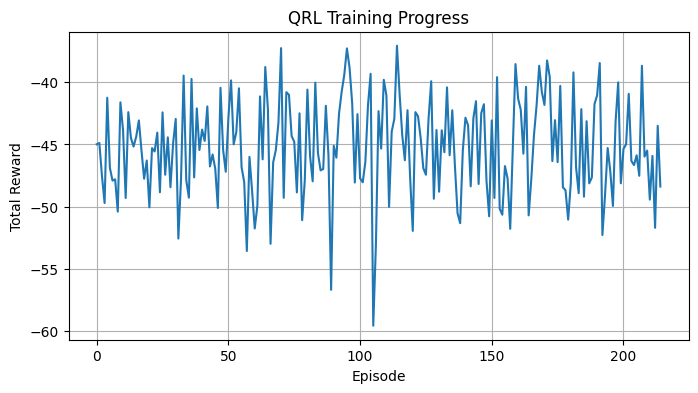

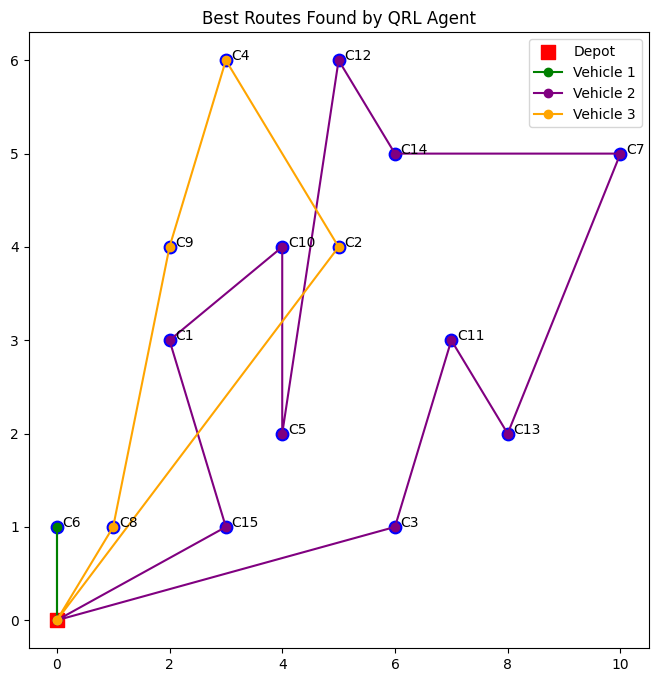

In [ ]:
# ==========================================================
# Quantum Reinforcement Learning for Vehicle Routing Problem
# 1 Depot, 15 Customers, 3 Vehicles
# Adaptive stopping + all vehicles encouraged
# ==========================================================

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

# -------------------------------
# ENVIRONMENT SETUP (15 customers)
# -------------------------------
class VRPEnvironment:
    def __init__(self):
        self.depot = (0, 0)
        self.customers = [
            (2, 3), (5, 4), (6, 1), (3, 6), (4, 2),
            (0, 1), (10, 5), (1, 1), (2, 4), (4, 4),
            (7, 3), (5, 6), (8, 2), (6, 5), (3, 1)
        ]
        self.num_customers = len(self.customers)
        self.num_vehicles = 3
        self.reset()

    def reset(self):
        self.visited = [False] * self.num_customers
        self.vehicle_positions = [self.depot for _ in range(self.num_vehicles)]
        self.total_distance = 0
        self.steps = 0
        return self._get_state()

    def _distance(self, a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def _get_state(self):
        state = []
        for pos in self.vehicle_positions:
            state.extend(list(pos))
        state.extend([1.0 if v else 0.0 for v in self.visited])
        return np.array(state)

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5, all(self.visited), 0  # penalty

        curr_pos = self.vehicle_positions[vehicle_idx]
        new_pos = self.customers[customer_idx]
        dist = self._distance(curr_pos, new_pos)
        self.vehicle_positions[vehicle_idx] = new_pos
        self.visited[customer_idx] = True
        self.total_distance += dist
        self.steps += 1

        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist


# -------------------------------
# QUANTUM POLICY NETWORK
# -------------------------------
n_qubits = 15  # one qubit per customer
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_policy(inputs, weights):
    # Encode classical state
    for i in range(n_qubits):
        qml.RY(inputs[i % len(inputs)], wires=i)

    # Variational circuit
    for i in range(n_qubits):
        qml.RY(weights[i, 0], wires=i)
        qml.RZ(weights[i, 1], wires=i)

    # Entanglement
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


class QuantumPolicy(nn.Module):
    def __init__(self, n_qubits):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_qubits, 2) * 0.1)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=False)
        probs = quantum_policy(x, self.weights)
        probs = torch.stack(probs)
        probs = (probs + 1) / 2
        return probs / torch.sum(probs)


# -------------------------------
# TRAINING LOOP WITH ADAPTIVE STOPPING
# -------------------------------
env = VRPEnvironment()
policy = QuantumPolicy(n_qubits)
optimizer = optim.Adam(policy.parameters(), lr=0.05)

max_episodes = 1000
patience = 100
episode_rewards = []
best_route = None
best_distance = float("inf")
no_improve_counter = 0

for ep in range(max_episodes):
    state = env.reset()
    total_reward = 0
    route_log = [[] for _ in range(env.num_vehicles)]
    route_distance = 0

    for step in range(30):  # max steps
        probs = policy(state)
        probs_np = probs.detach().numpy()[:env.num_customers]

        # Mask visited customers
        mask = np.array([0 if v else 1 for v in env.visited])
        masked_probs = probs_np * mask

        if masked_probs.sum() == 0:
            break  # all customers visited

        masked_probs = masked_probs / masked_probs.sum()

        # Choose customer
        customer_idx = np.random.choice(env.num_customers, p=masked_probs)

        # Choose vehicle: nearest with tie-breaking
        customer_pos = env.customers[customer_idx]
        distances = [env._distance(vehicle_pos, customer_pos) for vehicle_pos in env.vehicle_positions]
        min_distance = min(distances)
        candidates = [i for i, d in enumerate(distances) if d == min_distance]
        vehicle_idx = random.choice(candidates)

        # Take step
        next_state, reward, done, dist = env.step(vehicle_idx, customer_idx)
        total_reward += reward
        route_distance += dist
        route_log[vehicle_idx].append(f"C{customer_idx + 1}")

        # Policy gradient update
        loss = -torch.log(probs[customer_idx] + 1e-6) * reward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        if done:
            break

    episode_rewards.append(total_reward)

    # Print episode summary
    print(f"\nEpisode {ep + 1}")
    for i, route in enumerate(route_log):
        if not route:
            print(f"  Vehicle {i+1}: Did not move.")
        else:
            print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
    print(f"  Total Distance: {route_distance:.3f}, Total Reward: {total_reward:.3f}")

    # Update best route
    if route_distance < best_distance:
        best_distance = route_distance
        best_route = route_log
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    # Adaptive early stopping
    if no_improve_counter >= patience:
        print(f"\nStopping early at episode {ep + 1} due to no improvement for {patience} episodes.")
        break

# -------------------------------
# RESULTS
# -------------------------------
print("\n===============================")
print("🏆 Best Route Found Across All Episodes:")
for i, route in enumerate(best_route):
    if not route:
        print(f"  Vehicle {i+1}: Did not move.")
    else:
        print(f"  Vehicle {i+1} route: Depot -> {' -> '.join(route)} -> Depot")
print(f"  🚗 Best Total Distance: {best_distance:.3f}")
print("===============================\n")

# -------------------------------
# VISUALIZATION
# -------------------------------
plt.figure(figsize=(8, 4))
plt.plot(episode_rewards)
plt.title("QRL Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

# Show best final routes visually
plt.figure(figsize=(8, 8))
plt.scatter(*env.depot, color="red", marker="s", s=100, label="Depot")
for i, c in enumerate(env.customers):
    plt.scatter(*c, color="blue", s=80)
    plt.text(c[0] + 0.1, c[1], f"C{i + 1}")

colors = ["green", "purple", "orange"]
for i, route in enumerate(best_route):
    if route:
        route_points = [env.depot] + [
            env.customers[int(r[1:]) - 1] for r in route
        ] + [env.depot]
        xs, ys = zip(*route_points)
        plt.plot(xs, ys, marker="o", linestyle="-", color=colors[i], label=f"Vehicle {i+1}")

plt.title("Best Routes Found by QRL Agent")
plt.legend()
plt.show()


In [ ]:
"""
Hybrid QRL for VRP with PennyLane (fully corrected)
- Attention-based classical encoder
- Quantum policy layer (PennyLane)
- REINFORCE training
- Reports best route, distance, memory usage
- No dtype errors
"""

import os
import random
import psutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml

# -------------------------------
# VRP Environment
# -------------------------------
class VRPEnvironment:
    def __init__(self, customers, num_vehicles=2):
        self.depot = np.array([0.0, 0.0], dtype=np.float32)
        self.customers = np.array(customers, dtype=np.float32)
        self.num_customers = len(self.customers)
        self.num_vehicles = num_vehicles
        self.reset()

    def reset(self):
        self.visited = np.zeros(self.num_customers, dtype=bool)
        self.vehicle_positions = np.tile(self.depot, (self.num_vehicles, 1)).astype(np.float32)
        self.total_distance = 0.0
        return self._get_state()

    def _distance(self, a, b):
        return np.linalg.norm(a - b)

    def _get_state(self):
        return np.concatenate([self.vehicle_positions.flatten(),
                               self.customers.flatten(),
                               self.visited.astype(np.float32)])

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5.0, all(self.visited), 0.0
        curr = self.vehicle_positions[vehicle_idx]
        target = self.customers[customer_idx]
        dist = self._distance(curr, target)
        self.vehicle_positions[vehicle_idx] = target.copy()
        self.visited[customer_idx] = True
        self.total_distance += dist
        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist

# -------------------------------
# Quantum circuit (PennyLane)
# -------------------------------
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def q_policy_qnode(encoded_angles, q_weights):
    # encoded_angles and q_weights are torch tensors (float32)
    encoded_angles = encoded_angles.float()
    q_weights = q_weights.float()
    for i in range(n_qubits):
        qml.RY(encoded_angles[i], wires=i)
    for i in range(n_qubits):
        qml.RY(q_weights[i,0], wires=i)
        qml.RZ(q_weights[i,1], wires=i)
        qml.RX(q_weights[i,2], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[n_qubits-1,0])
    return qml.expval(qml.PauliZ(0))

# -------------------------------
# Hybrid Attention + Quantum Policy
# -------------------------------
class HybridQRLPolicy(nn.Module):
    def __init__(self, embed_dim=64, n_heads=4, n_qubits_local=n_qubits):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.n_qubits = n_qubits_local

        self.customer_embed = nn.Sequential(
            nn.Linear(3, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.vehicle_embed = nn.Sequential(
            nn.Linear(2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.attention = nn.MultiheadAttention(embed_dim, n_heads, batch_first=True)
        self.classical_to_qubits = nn.Linear(embed_dim, self.n_qubits)
        self.q_weights = nn.Parameter(0.01 * torch.randn(self.n_qubits,3,dtype=torch.float32))
        self.post_proc = nn.Linear(1,1)

    def forward(self, vehicle_positions_np, customer_positions_np, visited_mask_np):
        device = next(self.parameters()).device
        vehicle_positions = torch.tensor(vehicle_positions_np, dtype=torch.float32, device=device)
        customer_positions = torch.tensor(customer_positions_np, dtype=torch.float32, device=device)
        visited_mask = torch.tensor(visited_mask_np, dtype=torch.float32, device=device)

        num_vehicles = vehicle_positions.shape[0]
        num_customers = customer_positions.shape[0]

        customer_input = torch.cat([customer_positions, visited_mask.unsqueeze(1)], dim=1)
        cust_emb = self.customer_embed(customer_input)
        veh_emb = self.vehicle_embed(vehicle_positions)
        queries = veh_emb.unsqueeze(0)
        keys_values = cust_emb.unsqueeze(0)
        attn_output, _ = self.attention(queries, keys_values, keys_values)
        attn_output = attn_output.squeeze(0)

        scores = torch.zeros((num_vehicles, num_customers), device=device, dtype=torch.float32)

        for v in range(num_vehicles):
            v_vec = attn_output[v].unsqueeze(0)
            pair_features = v_vec * cust_emb
            angles = self.classical_to_qubits(pair_features)
            angles = torch.tanh(angles) * np.pi
            for c in range(num_customers):
                if visited_mask[c] >= 0.5:
                    scores[v,c] = -1e6
                    continue
                encoded_angles = angles[c]
                q_out = q_policy_qnode(encoded_angles, self.q_weights)
                q_out = q_out.float()  # FIX dtype mismatch
                q_score = self.post_proc(q_out.unsqueeze(0)).squeeze(0)
                scores[v,c] = (q_score + 1.0) * 0.5
        probs = torch.softmax(scores, dim=1)
        return probs

# -------------------------------
# REINFORCE training
# -------------------------------
def train_hybrid_qrl(customers,
                     num_vehicles=2,
                     episodes=50,
                     max_steps_per_episode=200,
                     lr=0.01,
                     save_path="hybrid_qrl.pth",
                     device="cpu"):
    env = VRPEnvironment(customers, num_vehicles=num_vehicles)
    policy = HybridQRLPolicy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    best_distance = float("inf")
    best_route = None
    episode_rewards = []
    mem_usage_records = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0
        route_log = [[] for _ in range(env.num_vehicles)]
        done = False
        steps = 0

        while not done and steps < max_steps_per_episode:
            vehicle_positions = env.vehicle_positions.copy()
            customer_positions = env.customers.copy()
            visited_mask = env.visited.astype(np.float32)
            probs = policy(vehicle_positions, customer_positions, visited_mask)
            probs_np = probs.detach().cpu().numpy()
            flat = probs_np.flatten()
            flat = np.maximum(flat, 0)
            if flat.sum() == 0:
                break
            flat = flat / flat.sum()
            idx = np.random.choice(len(flat), p=flat)
            vehicle_idx = idx // env.num_customers
            customer_idx = idx % env.num_customers
            _, reward, done, dist = env.step(vehicle_idx, customer_idx)
            total_reward += reward
            route_log[vehicle_idx].append(f"C{customer_idx+1}")

            optimizer.zero_grad()
            probs_tensor = policy(vehicle_positions, customer_positions, visited_mask)
            prob_taken = probs_tensor[vehicle_idx, customer_idx]
            loss = -torch.log(prob_taken + 1e-8) * reward
            loss.backward()
            optimizer.step()
            steps += 1

        episode_rewards.append(total_reward)
        mem = psutil.Process(os.getpid()).memory_info().rss / (1024*1024)
        mem_usage_records.append(mem)
        if env.total_distance < best_distance:
            best_distance = env.total_distance
            best_route = route_log

        print(f"Episode {ep+1}/{episodes}  Distance: {env.total_distance:.3f}  Reward: {total_reward:.3f}  Mem(MB): {mem:.1f}")

    torch.save(policy.state_dict(), save_path)
    avg_mem = float(np.mean(mem_usage_records))

    return policy, best_route, best_distance, episode_rewards, avg_mem

# -------------------------------
# MAIN
# -------------------------------
if __name__ == "__main__":
    customers = [
        (2, 3), (5, 4), (6, 1), (3, 6), (4, 2),
        (0, 1), (10, 5), (1, 1), (2, 4), (4, 4)
    ]
    num_vehicles = 2
    episodes = 50
    device = "cpu"
    save_path = "hybrid_qrl_policy.pth"

    # Train
    policy, best_route, best_distance, rewards, avg_mem = train_hybrid_qrl(
        customers, num_vehicles=num_vehicles, episodes=episodes, save_path=save_path, device=device
    )

    print("\n=== Training finished ===")
    print("Best distance found:", best_distance)
    print("Best route (per vehicle):", best_route)
    print(f"Average memory usage during training: {avg_mem:.2f} MB")


Episode 1/50  Distance: 48.454  Reward: -48.454  Mem(MB): 875.4
Episode 2/50  Distance: 44.100  Reward: -44.100  Mem(MB): 876.9
Episode 3/50  Distance: 45.103  Reward: -45.103  Mem(MB): 877.2
Episode 4/50  Distance: 42.475  Reward: -42.475  Mem(MB): 877.3
Episode 5/50  Distance: 36.930  Reward: -36.930  Mem(MB): 877.3
Episode 6/50  Distance: 49.239  Reward: -49.239  Mem(MB): 877.3
Episode 7/50  Distance: 44.688  Reward: -44.688  Mem(MB): 877.3
Episode 8/50  Distance: 35.084  Reward: -35.084  Mem(MB): 877.3
Episode 9/50  Distance: 48.868  Reward: -48.868  Mem(MB): 877.3
Episode 10/50  Distance: 44.191  Reward: -44.191  Mem(MB): 877.3
Episode 11/50  Distance: 43.721  Reward: -43.721  Mem(MB): 877.3
Episode 12/50  Distance: 42.093  Reward: -42.093  Mem(MB): 877.3
Episode 13/50  Distance: 46.742  Reward: -46.742  Mem(MB): 877.3
Episode 14/50  Distance: 44.288  Reward: -44.288  Mem(MB): 877.4
Episode 15/50  Distance: 50.356  Reward: -50.356  Mem(MB): 877.4
Episode 16/50  Distance: 39.497  R

Episode 1  Distance: 34.966  Reward: -34.966  Mem(MB): 873.6
Episode 2  Distance: 36.934  Reward: -36.934  Mem(MB): 875.1
Episode 3  Distance: 44.974  Reward: -44.974  Mem(MB): 875.4
Episode 4  Distance: 31.330  Reward: -31.330  Mem(MB): 875.5
Episode 5  Distance: 33.183  Reward: -33.183  Mem(MB): 875.5
Episode 6  Distance: 34.009  Reward: -34.009  Mem(MB): 875.5
Episode 7  Distance: 43.234  Reward: -43.234  Mem(MB): 875.5
Episode 8  Distance: 40.450  Reward: -40.450  Mem(MB): 875.6
Episode 9  Distance: 32.976  Reward: -32.976  Mem(MB): 875.6
Episode 10  Distance: 39.721  Reward: -39.721  Mem(MB): 875.6
Episode 11  Distance: 34.995  Reward: -34.995  Mem(MB): 875.6
Episode 12  Distance: 35.183  Reward: -35.183  Mem(MB): 875.6
Episode 13  Distance: 31.045  Reward: -31.045  Mem(MB): 875.6
Episode 14  Distance: 27.362  Reward: -27.362  Mem(MB): 875.6
Episode 15  Distance: 34.145  Reward: -34.145  Mem(MB): 875.6
Episode 16  Distance: 32.567  Reward: -32.567  Mem(MB): 875.6
Episode 17  Dista

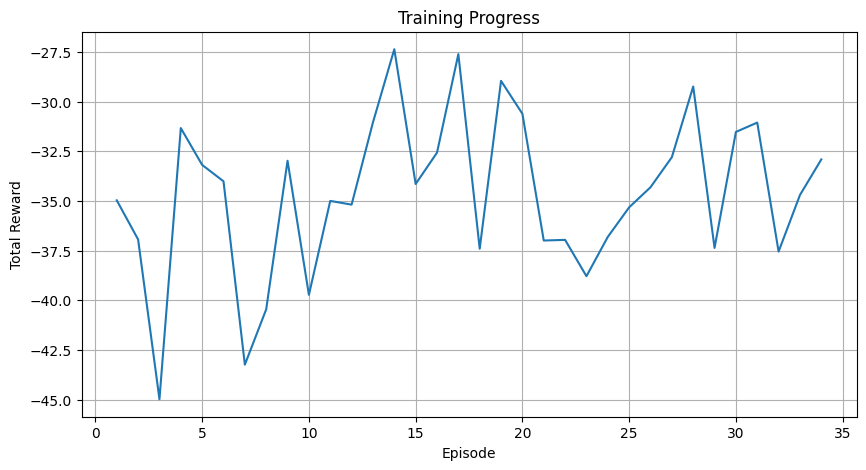

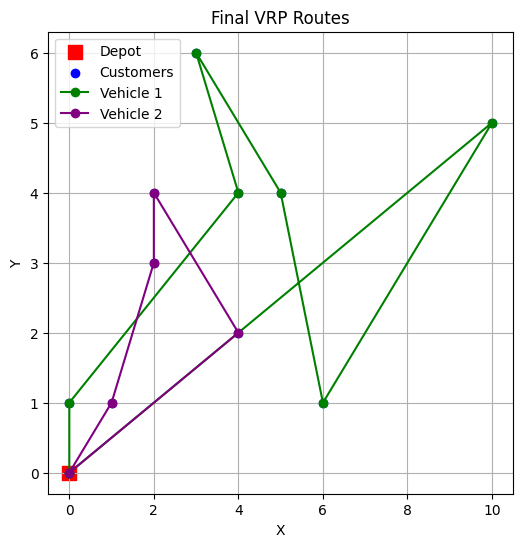

In [ ]:
"""

-------------------MAIN-------------------

Hybrid QRL for VRP with Early Stopping
- Classical attention encoder
- Quantum policy (PennyLane)
- REINFORCE training
- Adaptive early stopping
- Nearest vehicle selection
"""

import os
import random
import psutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

# -------------------------------
# VRP ENVIRONMENT
# -------------------------------
class VRPEnvironment:
    def __init__(self, customers, num_vehicles=2):
        self.depot = np.array([0.0, 0.0])
        self.customers = np.array(customers, dtype=float)
        self.num_customers = len(self.customers)
        self.num_vehicles = num_vehicles
        self.reset()

    def reset(self):
        self.visited = np.zeros(self.num_customers, dtype=bool)
        self.vehicle_positions = np.tile(self.depot, (self.num_vehicles, 1)).astype(float)
        self.total_distance = 0.0
        return self._get_state()

    def _distance(self, a, b):
        return np.linalg.norm(a - b)

    def _get_state(self):
        return np.concatenate([self.vehicle_positions.flatten(),
                               self.customers.flatten(),
                               self.visited.astype(float)])

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5.0, all(self.visited), 0.0
        curr = self.vehicle_positions[vehicle_idx]
        target = self.customers[customer_idx]
        dist = self._distance(curr, target)
        self.vehicle_positions[vehicle_idx] = target.copy()
        self.visited[customer_idx] = True
        self.total_distance += dist
        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist

# -------------------------------
# QUANTUM CIRCUIT
# -------------------------------
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def q_policy_qnode(encoded_angles, q_weights):
    for i in range(n_qubits):
        qml.RY(encoded_angles[i], wires=i)
    for i in range(n_qubits):
        qml.RY(q_weights[i,0], wires=i)
        qml.RZ(q_weights[i,1], wires=i)
        qml.RX(q_weights[i,2], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[n_qubits-1,0])
    return qml.expval(qml.PauliZ(0))

# -------------------------------
# HYBRID QRL POLICY
# -------------------------------
class HybridQRLPolicy(nn.Module):
    def __init__(self, embed_dim=64, n_heads=4, n_qubits_local=n_qubits):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.n_qubits = n_qubits_local

        self.customer_embed = nn.Sequential(
            nn.Linear(3, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.vehicle_embed = nn.Sequential(
            nn.Linear(2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )
        self.attention = nn.MultiheadAttention(embed_dim, n_heads, batch_first=True)
        self.classical_to_qubits = nn.Linear(embed_dim, self.n_qubits)
        self.q_weights = nn.Parameter(0.01 * torch.randn(self.n_qubits,3,dtype=torch.float32))
        self.post_proc = nn.Linear(1,1)

    def forward(self, vehicle_positions_np, customer_positions_np, visited_mask_np):
        device = next(self.parameters()).device
        vehicle_positions = torch.tensor(vehicle_positions_np, dtype=torch.float32, device=device)
        customer_positions = torch.tensor(customer_positions_np, dtype=torch.float32, device=device)
        visited_mask = torch.tensor(visited_mask_np, dtype=torch.float32, device=device)

        num_vehicles = vehicle_positions.shape[0]
        num_customers = customer_positions.shape[0]

        customer_input = torch.cat([customer_positions, visited_mask.unsqueeze(1)], dim=1)
        cust_emb = self.customer_embed(customer_input)
        veh_emb = self.vehicle_embed(vehicle_positions)
        queries = veh_emb.unsqueeze(0)
        keys_values = cust_emb.unsqueeze(0)
        attn_output, _ = self.attention(queries, keys_values, keys_values)
        attn_output = attn_output.squeeze(0)

        scores = torch.zeros((num_vehicles, num_customers), device=device, dtype=torch.float32)

        for v in range(num_vehicles):
            v_vec = attn_output[v].unsqueeze(0)
            pair_features = v_vec * cust_emb
            angles = self.classical_to_qubits(pair_features)
            angles = torch.tanh(angles) * np.pi
            for c in range(num_customers):
                if visited_mask[c] >= 0.5:
                    scores[v,c] = -1e6
                    continue
                encoded_angles = angles[c]
                q_out = q_policy_qnode(encoded_angles, self.q_weights)
                q_out = q_out.to(torch.float32)  # <-- fix for double/float mismatch
                q_score = self.post_proc(q_out.unsqueeze(0)).squeeze(0)
                scores[v,c] = (q_score + 1.0) * 0.5
        probs = torch.softmax(scores, dim=1)
        return probs

# -------------------------------
# TRAINING WITH EARLY STOPPING
# -------------------------------
def train_hybrid_qrl(customers, num_vehicles=2, max_episodes=1000, patience=100, lr=0.01, device="cpu"):
    env = VRPEnvironment(customers, num_vehicles=num_vehicles)
    policy = HybridQRLPolicy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    best_distance = float("inf")
    best_route = None
    episode_rewards = []
    mem_usage_records = []
    no_improve_counter = 0

    ep = 0
    while ep < max_episodes:
        ep += 1
        state = env.reset()
        total_reward = 0.0
        route_log = [[] for _ in range(num_vehicles)]
        done = False
        steps = 0

        while not done and steps < 200:
            vehicle_positions = env.vehicle_positions.copy()
            customer_positions = env.customers.copy()
            visited_mask = env.visited.astype(float)
            probs = policy(vehicle_positions, customer_positions, visited_mask)
            flat = probs.detach().cpu().numpy().flatten()
            flat = np.maximum(flat, 0)
            if flat.sum() == 0:
                break
            flat /= flat.sum()
            idx = np.random.choice(len(flat), p=flat)
            vehicle_idx = idx // env.num_customers
            customer_idx = idx % env.num_customers

            # Nearest vehicle logic
            customer_pos = env.customers[customer_idx]
            distances = [env._distance(pos, customer_pos) for pos in env.vehicle_positions]
            min_dist = min(distances)
            candidates = [i for i,d in enumerate(distances) if d==min_dist]
            if vehicle_idx not in candidates:
                vehicle_idx = random.choice(candidates)

            _, reward, done, dist = env.step(vehicle_idx, customer_idx)
            total_reward += reward
            route_log[vehicle_idx].append(f"C{customer_idx+1}")

            optimizer.zero_grad()
            probs_tensor = policy(vehicle_positions, customer_positions, visited_mask)
            prob_taken = probs_tensor[vehicle_idx, customer_idx]
            loss = -torch.log(prob_taken + 1e-8) * reward
            loss.backward()
            optimizer.step()
            steps += 1

        episode_rewards.append(total_reward)
        mem_usage_records.append(psutil.Process(os.getpid()).memory_info().rss / (1024*1024))

        if env.total_distance < best_distance:
            best_distance = env.total_distance
            best_route = route_log
            no_improve_counter = 0
        else:
            no_improve_counter += 1

        print(f"Episode {ep}  Distance: {env.total_distance:.3f}  Reward: {total_reward:.3f}  Mem(MB): {mem_usage_records[-1]:.1f}")

        if no_improve_counter >= patience:
            print(f"\nStopping early at episode {ep} (no improvement in {patience} episodes)")
            break

    return policy, best_route, best_distance, episode_rewards, np.mean(mem_usage_records)

# -------------------------------
# VISUALIZATION
# -------------------------------
def plot_training(rewards):
    plt.figure(figsize=(10,5))
    plt.plot(range(1,len(rewards)+1), rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.grid(True)
    plt.show()

def plot_vrp_route(customers, route_log):
    plt.figure(figsize=(6,6))
    depot = np.array([0,0])
    plt.scatter(*depot, c='red', marker='s', s=100, label='Depot')
    cust_array = np.array(customers)
    plt.scatter(cust_array[:,0], cust_array[:,1], c='blue', label='Customers')
    colors = ['green','purple','orange','cyan','magenta']
    for v_idx, route in enumerate(route_log):
        if not route:
            continue
        positions = [depot] + [customers[int(r[1:])-1] for r in route] + [depot]
        positions = np.array(positions)
        plt.plot(positions[:,0], positions[:,1], marker='o', color=colors[v_idx % len(colors)], label=f"Vehicle {v_idx+1}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Final VRP Routes")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# MAIN
# -------------------------------
if __name__ == "__main__":
    customers = [
        (2, 3), (5, 4), (6, 1), (3, 6), (4, 2),
        (0, 1), (10, 5), (1, 1), (2, 4), (4, 4)
    ]
    num_vehicles = 2

    policy, best_route, best_distance, rewards, avg_mem = train_hybrid_qrl(
        customers, num_vehicles=num_vehicles, max_episodes=1000, patience=20, lr=0.01, device="cpu"
    )

    # Save the trained model
    save_path = "hybrid_qrl_policy.pth"
    torch.save(policy.state_dict(), save_path)

    # Print confirmation and full path
    full_path = os.path.abspath(save_path)
    print(f"✅ Hybrid QRL model saved successfully at: {full_path}")


    print("\n=== Training Finished ===")
    print(f"Best Distance: {best_distance:.3f}")
    print(f"Best Route: {best_route}")
    print(f"Average Memory Usage: {avg_mem:.2f} MB")

    plot_training(rewards)
    plot_vrp_route(customers, best_route)


✅ Loaded saved model from: /content/hybrid_qrl_policy.pth
Episode 1  Distance: 74.896  Reward: -74.896  Mem(MB): 1041.8
Episode 2  Distance: 62.597  Reward: -62.597  Mem(MB): 1051.6
Episode 3  Distance: 63.854  Reward: -63.854  Mem(MB): 1052.2
Episode 4  Distance: 69.954  Reward: -69.954  Mem(MB): 1043.9
Episode 5  Distance: 66.337  Reward: -66.337  Mem(MB): 1042.7
Episode 6  Distance: 65.820  Reward: -65.820  Mem(MB): 1051.5
Episode 7  Distance: 56.131  Reward: -56.131  Mem(MB): 1041.3
Episode 8  Distance: 60.578  Reward: -60.578  Mem(MB): 1033.9
Episode 9  Distance: 65.654  Reward: -65.654  Mem(MB): 1051.3
Episode 10  Distance: 69.814  Reward: -69.814  Mem(MB): 1044.3
Episode 11  Distance: 63.713  Reward: -63.713  Mem(MB): 1043.4
Episode 12  Distance: 62.451  Reward: -62.451  Mem(MB): 1053.4
Episode 13  Distance: 64.923  Reward: -64.923  Mem(MB): 1037.9
Episode 14  Distance: 66.589  Reward: -66.589  Mem(MB): 1051.3
Episode 15  Distance: 69.051  Reward: -69.051  Mem(MB): 1042.1
Episod

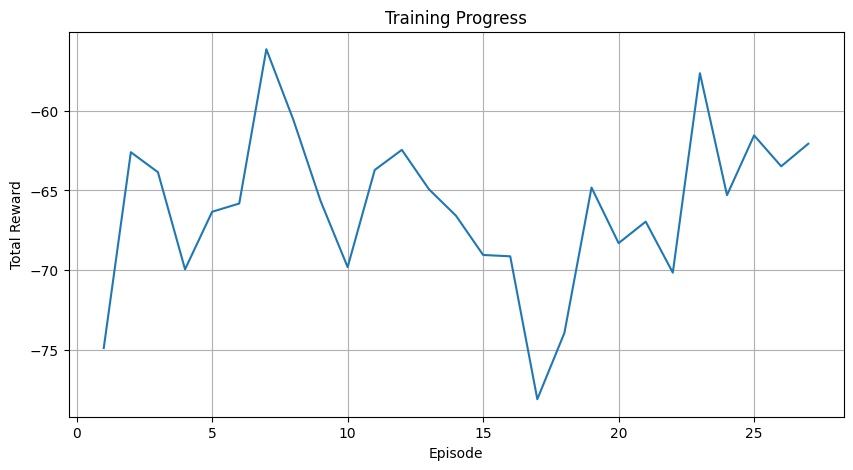

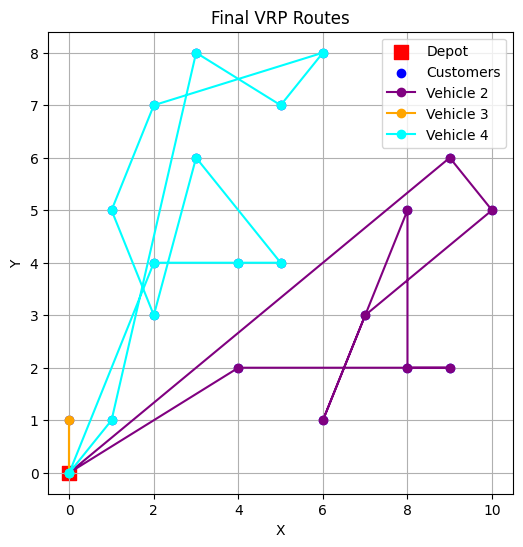

In [ ]:
import os
import torch

# Define your new dataset
new_customers = [
    (2,3),(5,4),(6,1),(3,6),(4,2),
    (0,1),(10,5),(1,1),(2,4),(4,4),
    (7,3),(8,2),(9,6),(3,8),(5,7),
    (1,5),(2,7),(6,8),(9,2),(8,5)
]
new_num_vehicles = 4
device = "cpu"

# Initialize the policy
policy = HybridQRLPolicy().to(device)

# Load previously saved weights if available
saved_model_path = "/content/hybrid_qrl_policy.pth"
if os.path.exists(saved_model_path):
    policy.load_state_dict(torch.load(saved_model_path, map_location=device))
    print(f"✅ Loaded saved model from: {saved_model_path}")
else:
    print("⚠️ Saved model not found. Training from scratch.")

# Train/fine-tune on new dataset
policy, best_route, best_distance, rewards, avg_mem = train_hybrid_qrl(
    new_customers, num_vehicles=new_num_vehicles,
    max_episodes=1000, patience=20, lr=0.01, device=device
)

# Save the fine-tuned model
torch.save(policy.state_dict(), saved_model_path)
print(f"✅ Fine-tuned model saved at: {os.path.abspath(saved_model_path)}")

# Show results
print("\n=== Fine-Tuning Finished ===")
print(f"Best Distance: {best_distance:.3f}")
print(f"Best Route: {best_route}")
print(f"Average Memory Usage: {avg_mem:.2f} MB")

# Visualize
plot_training(rewards)
plot_vrp_route(new_customers, best_route)


✅ Loaded trained model for testing.

=== Test Finished ===
Vehicle 1 route: Depot -> C1 -> C10 -> Depot
Vehicle 2 route: Depot -> C8 -> C3 -> C14 -> C11 -> C9 -> C7 -> C5 -> Depot
Vehicle 3 route: Depot -> C13 -> C2 -> C15 -> C12 -> C4 -> C6 -> Depot
Total Distance: 42.236


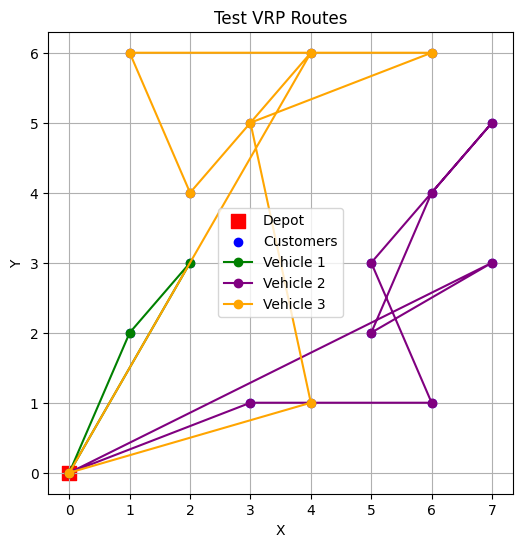

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


device = "cpu"


test_customers = [
    (1, 2), (3, 5), (6, 1), (2, 4), (7, 3),
    (4, 6), (5, 2), (3, 1), (6, 4), (2, 3),
    (7, 5), (1, 6), (4, 1), (5, 3), (6, 6)
]
num_test_vehicles = 3


policy = HybridQRLPolicy().to(device)
model_path = "/content/hybrid_qrl_policy.pth"
policy.load_state_dict(torch.load(model_path, map_location=device))
policy.eval()
print("✅ Loaded trained model for testing.")


class VRPEnvironmentTest:
    def __init__(self, customers, num_vehicles):
        self.depot = np.array([0.0, 0.0])
        self.customers = np.array(customers, dtype=float)
        self.num_customers = len(customers)
        self.num_vehicles = num_vehicles
        self.reset()

    def reset(self):
        self.visited = np.zeros(self.num_customers, dtype=bool)
        self.vehicle_positions = np.tile(self.depot, (self.num_vehicles, 1)).astype(float)
        self.total_distance = 0.0
        return self._get_state()

    def _distance(self, a, b):
        return np.linalg.norm(a - b)

    def _get_state(self):
        return np.concatenate([self.vehicle_positions.flatten(),
                               self.customers.flatten(),
                               self.visited.astype(float)])

    def step(self, vehicle_idx, customer_idx):
        if self.visited[customer_idx]:
            return self._get_state(), -5.0, all(self.visited), 0.0
        curr = self.vehicle_positions[vehicle_idx]
        target = self.customers[customer_idx]
        dist = self._distance(curr, target)
        self.vehicle_positions[vehicle_idx] = target.copy()
        self.visited[customer_idx] = True
        self.total_distance += dist
        done = all(self.visited)
        reward = -dist
        return self._get_state(), reward, done, dist

env = VRPEnvironmentTest(test_customers, num_test_vehicles)
route_log = [[] for _ in range(num_test_vehicles)]
done = False
steps = 0

while not done and steps < 200:
    vehicle_positions = env.vehicle_positions.copy()
    customer_positions = env.customers.copy()
    visited_mask = env.visited.astype(float)

    with torch.no_grad():
        probs = policy(vehicle_positions, customer_positions, visited_mask)

    flat = probs.cpu().numpy().flatten()
    flat = np.maximum(flat, 0)
    if flat.sum() == 0:
        break
    flat /= flat.sum()
    idx = np.random.choice(len(flat), p=flat)
    vehicle_idx = idx // env.num_customers
    customer_idx = idx % env.num_customers

    customer_pos = env.customers[customer_idx]
    distances = [env._distance(pos, customer_pos) for pos in env.vehicle_positions]
    min_dist = min(distances)
    candidates = [i for i,d in enumerate(distances) if d==min_dist]
    if vehicle_idx not in candidates:
        vehicle_idx = np.random.choice(candidates)

    _, _, done, _ = env.step(vehicle_idx, customer_idx)
    route_log[vehicle_idx].append(f"C{customer_idx+1}")
    steps += 1


print("\n=== Test Finished ===")
for v_idx, route in enumerate(route_log):
    print(f"Vehicle {v_idx+1} route: Depot -> {' -> '.join(route)} -> Depot")
print(f"Total Distance: {env.total_distance:.3f}")


def plot_vrp_route(customers, route_log):
    plt.figure(figsize=(6,6))
    depot = np.array([0,0])
    plt.scatter(*depot, c='red', marker='s', s=100, label='Depot')
    cust_array = np.array(customers)
    plt.scatter(cust_array[:,0], cust_array[:,1], c='blue', label='Customers')
    colors = ['green','purple','orange','cyan','magenta']
    for v_idx, route in enumerate(route_log):
        if not route:
            continue
        positions = [depot] + [customers[int(r[1:])-1] for r in route] + [depot]
        positions = np.array(positions)
        plt.plot(positions[:,0], positions[:,1], marker='o', color=colors[v_idx % len(colors)], label=f"Vehicle {v_idx+1}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Test VRP Routes")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_vrp_route(test_customers, route_log)
